datetime: 년-월-일 시간 데이터  
season: 1 = 봄, 2 = 여름, 3 = 가을, 4 = 겨울   
holiday: 공휴일 또는 주말  
workingday: 공휴일, 주말을 제외한 평일    
weather   
1: 매우 맑음(Clear, Few clouds, Partly cloudy, Partly cloudy)   
2: 맑음(Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist)  
3: 나쁨(Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds)   
4: 매우 나쁨(Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog)   
temp: 기온   
atemp: 체감온도 정도로 보자 
humidity: 상대 습도   
windspeed: 바람의 세기   
casual: 미등록 사용자 렌탈 수  
registered: 등록된 사용자 렌탈수   
count: 렌탈한 총 합   

In [1]:
library(tidyverse) # dataframe
library(lubridate) # datetime
library(stringr)   # string
library(caret)     # ?
library(readr)     # ?
library(gridExtra) # plot
library(xgboost)   # xgboost 
library(Metrics)   # metrics
library(ggplot2)   # plot
library(patchwork) # plot

── Attaching packages ─────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.4     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.0

── Conflicts ────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘lubridate’


The following objects are masked from ‘package:base’:

    date, intersect, setdiff, union


Loading required package: lattice


Attaching package: ‘caret’


The following object is masked from ‘package:purrr’:

    lift



Attaching package: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    combine



Attaching package: ‘xgboost’


The following object is masked from ‘package:dplyr’:

    slice



Attaching package: ‘Metrics’


The following objects are masked from ‘packag

In [2]:
# 데이터 불러오기

# read_csv 는 columns info를 알려준다.

train=read_csv("bike-sharing-demand/train.csv")
test=read_csv("bike-sharing-demand/test.csv")
submission=read_csv("bike-sharing-demand/sampleSubmission.csv")


── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────
cols(
  datetime = col_datetime(format = ""),
  season = col_double(),
  holiday = col_double(),
  workingday = col_double(),
  weather = col_double(),
  temp = col_double(),
  atemp = col_double(),
  humidity = col_double(),
  windspeed = col_double(),
  casual = col_double(),
  registered = col_double(),
  count = col_double()
)



── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────
cols(
  datetime = col_datetime(format = ""),
  season = col_double(),
  holiday = col_double(),
  workingday = col_double(),
  weather = col_double(),
  temp = col_double(),
  atemp = col_double(),
  humidity = col_double(),
  windspeed = col_double()
)



── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────
cols(
  datetime = col_datetime(format = "

In [3]:
# - 로 편하게 뺄 수 있다.
# - 로 빼고 남은것을 보여준다.

# lubridate 는 빼고 나서 숫자형으로 바꿔준다. 
train=train %>% select(-casual,-registered) %>%
mutate(year=year(datetime),
       month=month(datetime),
       hour=hour(datetime),
       wday=wday(datetime))

test=test %>%
mutate(year=year(datetime),
       month=month(datetime),
       hour=hour(datetime),
       wday=wday(datetime))

In [4]:
# str(dataframe) 으로 dataframe 정보를 알 수 있다. 

str(train)

tibble [10,886 × 14] (S3: tbl_df/tbl/data.frame)
 $ datetime  : POSIXct[1:10886], format: "2011-01-01 00:00:00" "2011-01-01 01:00:00" ...
 $ season    : num [1:10886] 1 1 1 1 1 1 1 1 1 1 ...
 $ holiday   : num [1:10886] 0 0 0 0 0 0 0 0 0 0 ...
 $ workingday: num [1:10886] 0 0 0 0 0 0 0 0 0 0 ...
 $ weather   : num [1:10886] 1 1 1 1 1 2 1 1 1 1 ...
 $ temp      : num [1:10886] 9.84 9.02 9.02 9.84 9.84 ...
 $ atemp     : num [1:10886] 14.4 13.6 13.6 14.4 14.4 ...
 $ humidity  : num [1:10886] 81 80 80 75 75 75 80 86 75 76 ...
 $ windspeed : num [1:10886] 0 0 0 0 0 ...
 $ count     : num [1:10886] 16 40 32 13 1 1 2 3 8 14 ...
 $ year      : num [1:10886] 2011 2011 2011 2011 2011 ...
 $ month     : num [1:10886] 1 1 1 1 1 1 1 1 1 1 ...
 $ hour      : int [1:10886] 0 1 2 3 4 5 6 7 8 9 ...
 $ wday      : num [1:10886] 7 7 7 7 7 7 7 7 7 7 ...


In [5]:
# 요약.
summary(train)

    datetime                       season         holiday       
 Min.   :2011-01-01 00:00:00   Min.   :1.000   Min.   :0.00000  
 1st Qu.:2011-07-02 07:15:00   1st Qu.:2.000   1st Qu.:0.00000  
 Median :2012-01-01 20:30:00   Median :3.000   Median :0.00000  
 Mean   :2011-12-27 05:56:22   Mean   :2.507   Mean   :0.02857  
 3rd Qu.:2012-07-01 12:45:00   3rd Qu.:4.000   3rd Qu.:0.00000  
 Max.   :2012-12-19 23:00:00   Max.   :4.000   Max.   :1.00000  
   workingday        weather           temp           atemp      
 Min.   :0.0000   Min.   :1.000   Min.   : 0.82   Min.   : 0.76  
 1st Qu.:0.0000   1st Qu.:1.000   1st Qu.:13.94   1st Qu.:16.66  
 Median :1.0000   Median :1.000   Median :20.50   Median :24.24  
 Mean   :0.6809   Mean   :1.418   Mean   :20.23   Mean   :23.66  
 3rd Qu.:1.0000   3rd Qu.:2.000   3rd Qu.:26.24   3rd Qu.:31.06  
 Max.   :1.0000   Max.   :4.000   Max.   :41.00   Max.   :45.45  
    humidity        windspeed          count            year     
 Min.   :  0.00  

In [6]:
# 결측치 파악.

sum(is.na(train))

[1] 0

In [7]:
# 시각화를 위한 준비
train_vis=train

# factor로 형변환 할 수 있다. label과 함께 쓴다.
train_vis$season=factor(train_vis$season,labels=c("Spring","Summer","Fall","Winter"))
train_vis$weather=factor(train_vis$weather,labels=c("Good","Normal","Bac","Very Bad"))
train_vis$holiday=factor(train_vis$holiday)
train_vis$workingday=factor(train_vis$workingday)
train_vis$year=factor(train_vis$year)
train_vis$month=factor(train_vis$month)
# train_vis$hour=factor(train_vis$hour)
train_vis$wday=factor(train_vis$wday,labels=c("Sun","Mon", "Tue","Wed","Thu","Fir","Sat"))

In [8]:
# colnames == df.columns 
# which 는 index 반환.

col_num_list=(colnames(train_vis) != "count") %>%
which()

Note: Using an external vector in selections is ambiguous.
ℹ Use `all_of(col_name)` instead of `col_name` to silence this message.
ℹ See <https://tidyselect.r-lib.org/reference/faq-external-vector.html>.
This message is displayed once per session.



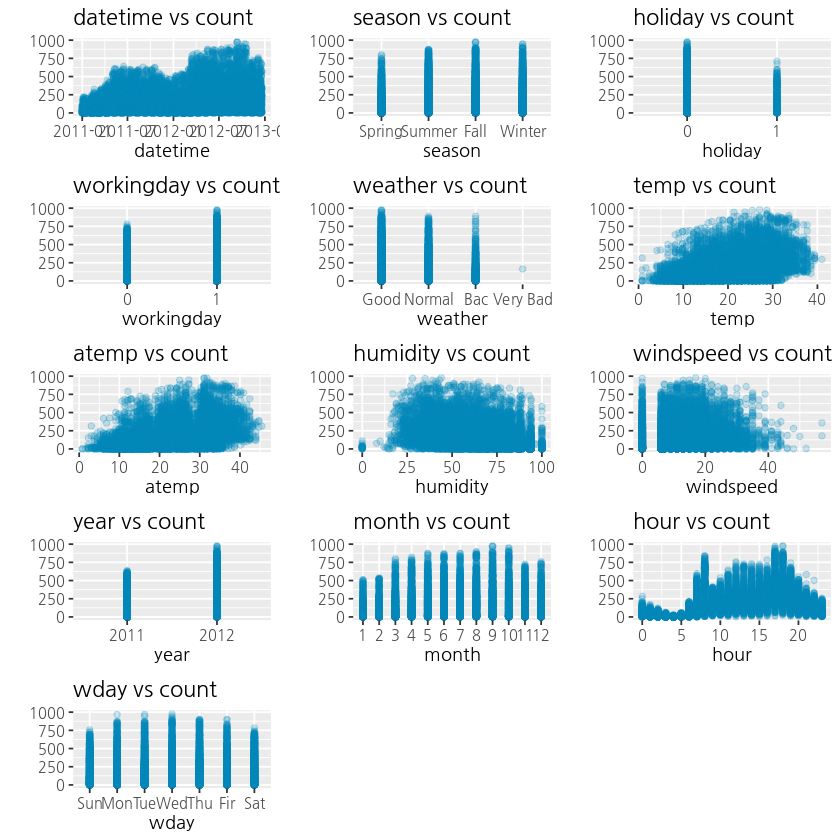

In [9]:
# colnames 로 건지고 rename으로 이름 바꿨다.
# 이걸 map으로 lst 안에 다 넣는것 같다.
# 여기서 발생하는 error는 col 이란 이름때문에 그렇다. 겹치는게 많으니 조심.
# col_name은 문자열이고, rename으로 해준 cc 가 변수를 포함한 벡터여서 rename을 해준것 같다. aes에는 x,y 벡터가 들어가야하기 때문이다. 
# grid는 list형태의 맵들을 한화면에 보여줄수 있게 한다.

group=map(col_num_list,function(i){
    col_name=colnames(train_vis)[i]
    
    train_vis %>% select(col_name,count) %>% 
    rename(cc=col_name) %>%
    ggplot(aes(x=cc,y=count))+
    geom_point(alpha=.2,color='#008ABC')+
    labs(title=paste(col_name,"vs count"),x=col_name,y="")
})

grid.arrange(grobs=group, ncol=3)

In [10]:
# is.factor로 True,False 가능. sapply 는 리스트? 로 변환 lapply 리스트로 변환. 
# colour 가 hue 느낌이다.
# group_by 다음에 summarise는 공식처럼.

factor_list=sapply(train_vis,is.factor) %>%
  which() %>% as.numeric()

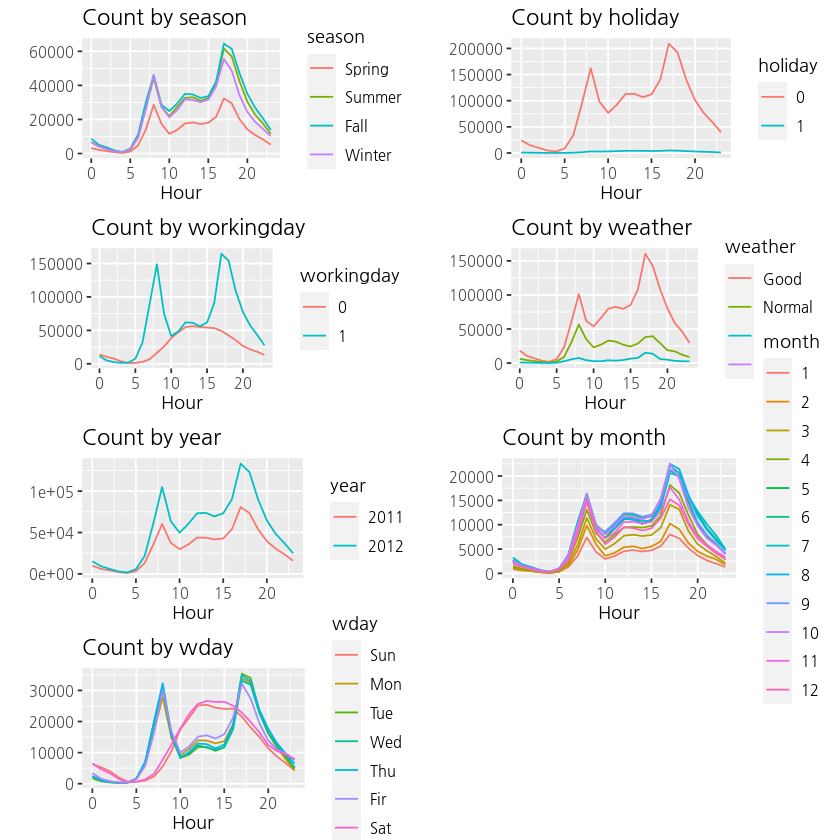

In [11]:
group=map(factor_list, function(i) {
    col_name=colnames(train_vis)[i]

    train_vis %>%
    rename(cc=col_name) %>%
    group_by(cc,hour) %>%
    summarise(count=sum(count),.groups='drop') %>%
    ggplot(aes(x=hour,y=count,group=cc,colour=cc))+
    labs(title=paste("Count by",col_name),x="Hour",y="",color=col_name)+
    geom_line()
})

grid.arrange(grobs=group,ncol=2)

In [12]:
train$count=log1p(train$count)

X_train=train %>%
select(-count,-datetime) %>%
as.matrix()

y_train=train$count

X_test=test %>%
select(-datetime) %>%
as.matrix()

In [13]:
dtrain=xgb.DMatrix(X_train,label=y_train)

searchGridSubCol=expand.grid(max_depth=c(13:15),
                             eta=c(0.3,0.1,0.35))

In [14]:
# apply : matrix ,열, 적용할 함수
# cv 는 train dataset 으로 validation 까지 하는것 같다. 
# tail로 1개만 얻는것 같다.

set.seed(71)

gs=apply(searchGridSubCol,1,function(params){
    current_depth=params[['max_depth']]
    current_eta=params[['eta']]
    
    cv=xgb.cv(data=dtrain,nrounds=100,nfold=5,showsd=TRUE,'objective'='reg:squarederror',
              metrics='rmse',verbose=TRUE,'eval_metric'='rmse',
              'max_depth'=current_depth,'eta'=current_eta,
              booster='gbtree',early_stopping_rounds=10,print_every_n=10)
    val_scores=as.data.frame(cv$evaluation_log)
    test_rmse=tail(val_scores$test_rmse_mean, 1)
    train_rmse=tail(val_scores$train_rmse_mean,1)
    output=return (c(test_rmse,train_rmse,current_depth,current_eta))
})

[1]	train-rmse:3.057414+0.003758	test-rmse:3.058661+0.015041 
Multiple eval metrics are present. Will use test_rmse for early stopping.
Will train until test_rmse hasn't improved in 10 rounds.

[11]	train-rmse:0.159503+0.001083	test-rmse:0.329186+0.009082 
[21]	train-rmse:0.052220+0.002222	test-rmse:0.307421+0.008499 
[31]	train-rmse:0.035069+0.001678	test-rmse:0.307092+0.008308 
[41]	train-rmse:0.022501+0.001441	test-rmse:0.307192+0.008247 
Stopping. Best iteration:
[31]	train-rmse:0.035069+0.001678	test-rmse:0.307092+0.008308

[1]	train-rmse:3.057370+0.003756	test-rmse:3.057966+0.013311 
Multiple eval metrics are present. Will use test_rmse for early stopping.
Will train until test_rmse hasn't improved in 10 rounds.

[11]	train-rmse:0.154540+0.000606	test-rmse:0.331350+0.006232 
[21]	train-rmse:0.040534+0.001528	test-rmse:0.309514+0.006972 
[31]	train-rmse:0.023770+0.001990	test-rmse:0.309230+0.007131 
[41]	train-rmse:0.014251+0.002296	test-rmse:0.309264+0.007145 
Stopping. Best iter

In [15]:
# t 함수는 transform 함수고, names 로 col_names 를 정할 수 있다.
output=as.data.frame(t(gs))
col_names=c("test_rmse","train_rmse","depth","eta")
names(output)=col_names

tail(output)

,test_rmse,train_rmse,depth,eta
,<dbl>,<dbl>,<dbl>,<dbl>
4,0.2930662,0.0333888,13,0.10
5,0.2952176,0.0244702,14,0.10
6,0.2998412,0.0182076,15,0.10
7,0.3134516,0.0156958,13,0.35
8,0.3158956,0.0184528,14,0.35
9,0.3132418,0.0115158,15,0.35


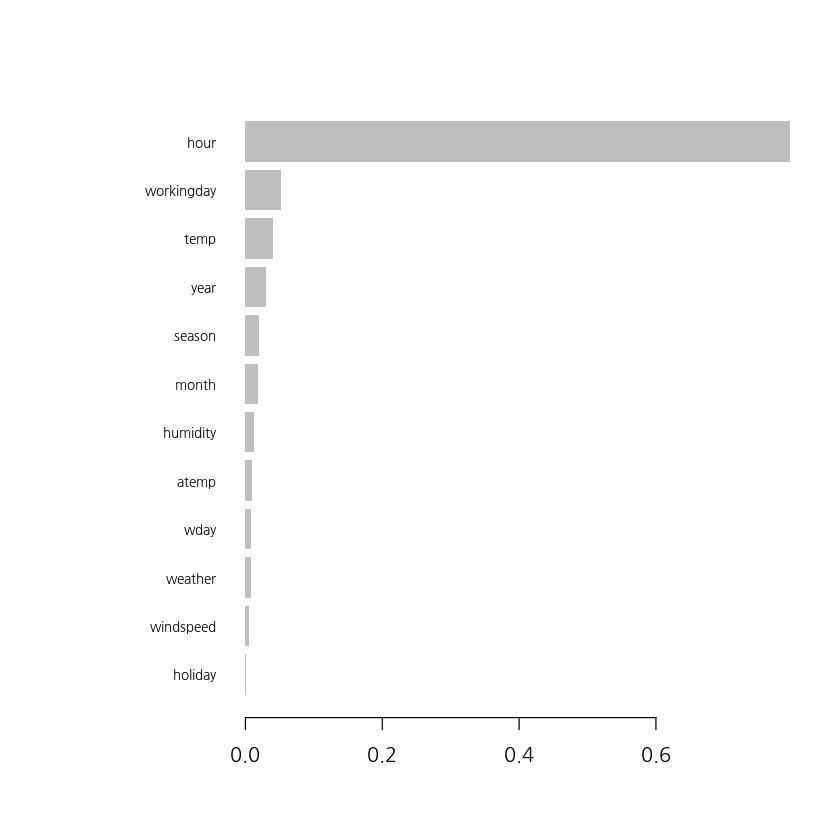

In [16]:
model=xgb.train(data=dtrain, 
                nround=100, 
                max_depth=14, 
                eta=0.1)

xgb.importance(feature_names=colnames(X_train),model) %>% 
xgb.plot.importance()

In [17]:
preds=predict(model,X_test)
preds=expm1(preds)

solution=data.frame(datetime=test$datetime,count=preds)

In [18]:
# write.csv(solution,"xgb_2021_01_05.csv",row.names=FALSE)